In [27]:
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [28]:
wd = Path("/home/ebelm/genomegraph/runs/20240903_replicate_STREME_results")
datadir = Path("/home/ebelm/genomegraph/data/STREME_benchmark_data")

In [29]:
ref_full = pd.read_csv(datadir / "full_ds_ref-motifs.tsv", sep="\t", names=["file", "motif"])
ref_hyb = pd.read_csv(datadir / "hybrid_ds_ref-motifs.tsv", sep="\t", names=["file", "motif"])

Accuracy

In [30]:
results_full = []
for file in ref_full["file"]:
    p = wd / "full" / file
    assert p.exists(), f"{p} does not exist"
    assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
    resultfile = p / "tomtom/tomtom.tsv"
    assert resultfile.exists(), f"{resultfile} does not exist"

    result = pd.read_csv(resultfile, sep="\t", comment="#")
    pval = result["p-value"].min()
    # negative log10 of p-value
    ppval = -math.log10(pval)
    results_full.append(ppval)

ref_full["pp-value"] = results_full

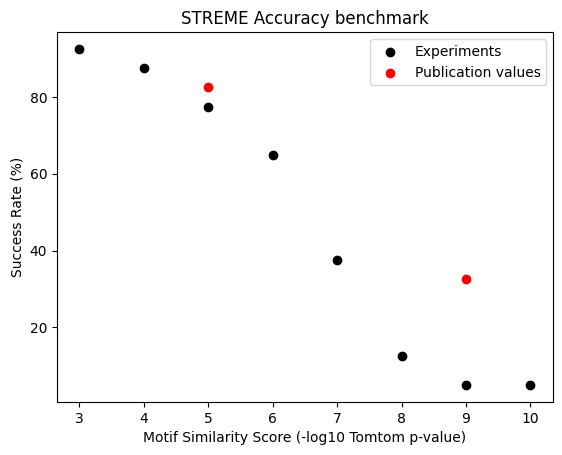

In [31]:
fig, ax = plt.subplots(1,1)
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value"] > i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="black")
ax.scatter(x=[5, 9],
           y=[82.5, 32.5],
           marker="o",
           color="red")
ax.set_xlabel("Motif Similarity Score (-log10 Tomtom p-value)")
ax.set_ylabel("Success Rate (%)")
ax.set_title("STREME Accuracy benchmark")
# add a legend in the plot
ax.legend(["Experiments", "Publication values"])
plt.show()

Sensitivity

In [32]:
results_diluted = {
    'purity': [],
    'success_rate': []
}
purities = sorted([d.name for d in (wd / 'diluted').iterdir() if d.is_dir()])
print(f"{purities=}")

for purity in purities:
    results_diluted['purity'].append(int(float(purity)*100))
    ny = 0
    for file in ref_full["file"]:
        p = wd / "diluted" / purity / file
        assert p.exists(), f"{p} does not exist"
        assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        if ppval >= 5:
            ny += 1

    results_diluted['success_rate'].append(ny*100/len(ref_full.index))

purities=['0.01', '0.02', '0.05', '0.10', '0.15', '0.20', '0.40', '0.60', '1.00']


In [33]:
results_diluted

{'purity': [1, 2, 5, 10, 15, 20, 40, 60, 100],
 'success_rate': [0.0, 5.0, 37.5, 52.5, 62.5, 77.5, 72.5, 72.5, 67.5]}

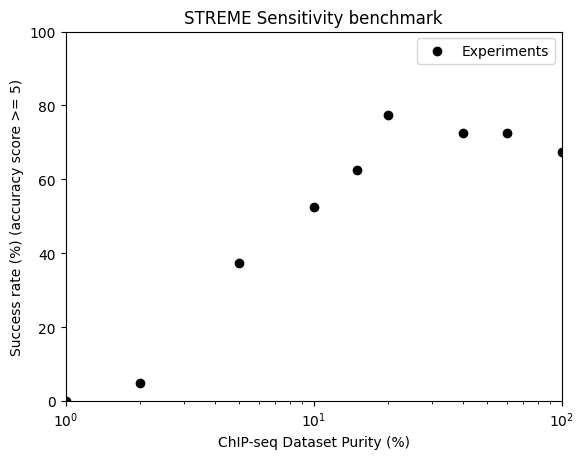

In [34]:
fig, ax = plt.subplots(1,1)
ax.scatter(x=results_diluted['purity'],
           y=results_diluted['success_rate'],
           marker="o",
           color="black")
# ax.scatter(x=[5, 9],
#            y=[82.5, 32.5],
#            marker="o",
#            color="red")
ax.set_xlabel("ChIP-seq Dataset Purity (%)")
ax.set_ylabel("Success rate (%) (accuracy score >= 5)")
ax.set_xscale("log")
ax.set_xlim(1, 100)
ax.set_ylim(0, 100)
ax.set_title("STREME Sensitivity benchmark")
# add a legend in the plot
ax.legend(["Experiments", "Publication values"])
plt.show()

Thoroughness

In [35]:
iterations = sorted([d.name for d in (wd / 'hybrid').iterdir() if d.is_dir()])
print(f"{iterations=}")

results_hybrid = {
    'pp_thresh': list(range(3,11)),
    'avg_success_rate': [],
    'std_success_rate': [],
}
for pp_t in results_hybrid['pp_thresh']:
    rates = []
    for it in iterations:
        ny = 0
        for file in ref_hyb["file"]:
            p = wd / "hybrid" / it / file
            assert p.exists(), f"{p} does not exist"
            assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
            resultfile = p / "tomtom/tomtom.tsv"
            assert resultfile.exists(), f"{resultfile} does not exist"

            result = pd.read_csv(resultfile, sep="\t", comment="#")
            pval = result["p-value"].min()
            # negative log10 of p-value
            ppval = -math.log10(pval)
            if ppval >= pp_t:
                ny += 1

        rates.append(ny*100/len(ref_full.index))

    results_hybrid['avg_success_rate'].append(sum(rates)/len(rates))
    results_hybrid['std_success_rate'].append(math.sqrt(sum([(r - results_hybrid['avg_success_rate'][-1])**2 for r in rates])/len(rates)))

iterations=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


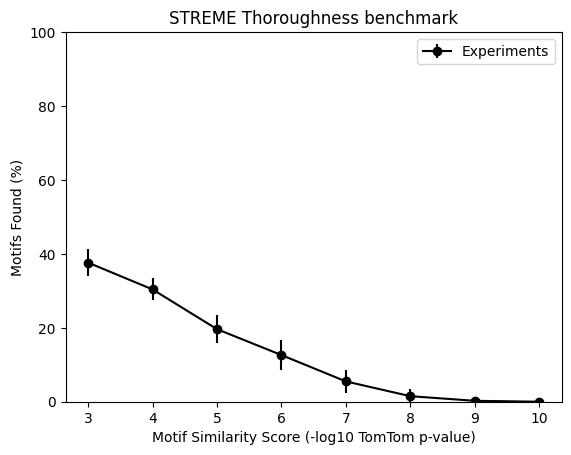

In [37]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x=results_hybrid['pp_thresh'],
           y=results_hybrid['avg_success_rate'],
           marker="o",
           yerr=results_hybrid['std_success_rate'],
           color="black")
# ax.scatter(x=[5, 9],
#            y=[82.5, 32.5],
#            marker="o",
#            color="red")
ax.set_xlabel("Motif Similarity Score (-log10 TomTom p-value)")
ax.set_ylabel("Motifs Found (%)")
ax.set_ylim(0, 100)
ax.set_title("STREME Thoroughness benchmark")
# add a legend in the plot
ax.legend(["Experiments", "Publication values"])
plt.show()